## ECE-UY 4563 Intro to Machine Learning Final Project - Dog Breed Classification 
* Presented by: Eren Tuksal(et2179@nyu.edu) and James Zhang(hz2852@nyu.edu)

In this project, we aim to develop a convolutional neural network capable of identifying 120 different dog breeds. The primary training dataset includes over 10,000 images of dogs captured from various angles and in diverse scenes. Additionally, there is a test dataset that includes not only dog images but also images of non-dog subjects, allowing us to evaluate the model's ability to differentiate between dog and non-dog images.

The following topics and techniques are covered:
* PyTorch
* Transfer Learning - ResNet18 model is used


## Import Packages and ResNet18
The image processor from ResNet18 is loaded, and the classsification model will be used for transfer learning

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage
from sklearn import linear_model, preprocessing
from transformers import AutoImageProcessor, AutoModelForImageClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18") # Load the image processor from ResNet18
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18").to(device) # Load the classification model

Using device: cuda


## Dog Time - Draw some dog pictures

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


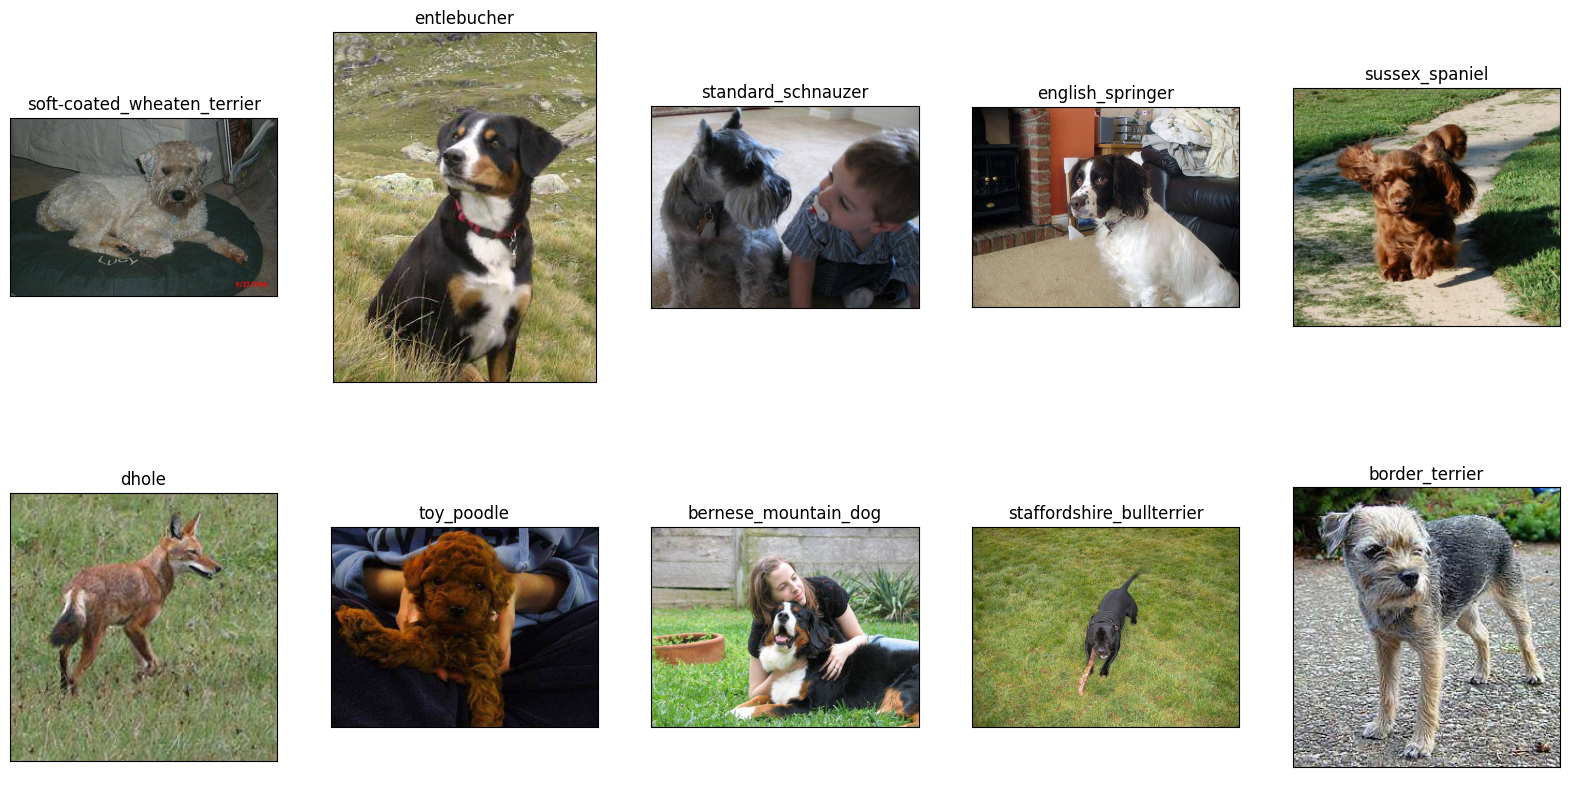

In [2]:
# load the labels
df = pd.read_csv('labels.csv')
print(df.head())
print(df.shape)

# display images function
def disp_image(im):
    # Color image.
    im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
    im1 = im1.astype(np.uint8)
    plt.imshow(im1)
    
    # Remove axis
    plt.xticks([])
    plt.yticks([])
    
plt.subplots(figsize=(20, 10))
plt.axis('off')
for i in range(10):
    plt.subplot(2, 5, i+1)
    k = np.random.randint(low=0,high=df.shape[0])
    fname = 'train/' + df['id'][k] + '.jpg'
    im_color = skimage.io.imread(fname)
    disp_image(im_color)
    plt.title(df.loc[k, 'breed'])


## Image Preprocess
Use the image processor from ResNet18 loaded before to preprocess the pictures
* Resize all input pictures into 224*224 pixels
* Transform image files into a Pytorch tensor 
* Put all tensors (images) into a list called inputs

In [3]:
# Convert dog breeds into numbers
le = preprocessing.LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])

# Preprocess images
inputs = [] # a list of tensor for each image
for im in range(df.shape[0]):
    fname = 'train/' + df['id'][im] + '.jpg' 
    input_image = skimage.io.imread(fname)
    input_tensor = image_processor(input_image, return_tensors="pt") # dictionary with one key called 'pixel_values', which related to the tensor for image
    inputs.append(input_tensor["pixel_values"][0]) # append each tensor for an image to inputs
print(inputs[0].shape) # print the 1st tensor shape to check


torch.Size([3, 224, 224])


In [4]:
# Transfer input list to a tensor
labels = df['breed']
input_batch = torch.stack(inputs).to(device)
print(labels.shape)
print(input_batch.shape)
print('There are ' + str(labels.nunique()) + ' unique individual breeds')

(10222,)
torch.Size([10222, 3, 224, 224])
There are 120 unique individual breeds


## Use the ResNet directly classify the image (WIP)

In [5]:
## USE RESNET-18 to determine the breed
# part_labels = labels[19]
# part_inputs = inputs[19]
# with torch.no_grad():  # No need to compute gradients during inference
#     output = model(part_inputs)
#     logits = output.logits

# print(logits.shape)
# probabilities = torch.nn.functional.softmax(logits, dim=-1)

# # Find the top 3 classes and their probabilities
# ntop = 3
# top_prob, top_catid = torch.topk(probabilities, ntop)

# # Convert to numpy
# top_prob = top_prob.numpy()
# top_catid = top_catid.numpy()
# print(top_catid)
# id2label = model.config.id2label
# print(id2label[top_catid[0][0]])

## Transfer Learning 
Modify loaded ResNet18. We will substitute the last output layer with our model.
* Change the output dimension to 120, number of breeds in dataset
* Freeze all layers except the last layer



In [6]:
# Modify the ResNet model
num_classes = 120
classifier = model.classifier[-1]  # Get the last layer (Linear)
# Modify the out_features into 120
model.classifier[-1] = nn.Linear(classifier.in_features, num_classes)

# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer so it can be trained
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

In [7]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
torch.cuda.empty_cache()
import gc
gc.collect()

# TODO
xtr, xts, ytr, yts = train_test_split(input_batch,labels,test_size=0.33)
print(xtr.shape)
print(xts.shape)

xtr = torch.tensor(xtr, dtype=torch.float32).to(device) # Ensure input is float tensor
xts = torch.tensor(xts, dtype=torch.float32).to(device)
ytr = torch.tensor(ytr.values, dtype=torch.int64).to(device)     # Ensure labels are integer tensor
yts = torch.tensor(yts.values, dtype=torch.int64).to(device)

# TODO:  Create a TensorDataset
train_dataset = TensorDataset(xtr, ytr)
test_dataset = TensorDataset(xts, yts)

# TODO:  Create a DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

import torch.optim as optim

# TODO: Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.Size([6848, 3, 224, 224])
torch.Size([3374, 3, 224, 224])


C:\Users\TUTU\AppData\Local\Temp\ipykernel_8280\171612799.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtr = torch.tensor(xtr, dtype=torch.float32).to(device) # Ensure input is float tensor
C:\Users\TUTU\AppData\Local\Temp\ipykernel_8280\171612799.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xts = torch.tensor(xts, dtype=torch.float32).to(device)


# Re-train the model

In [9]:
# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 20

# Training loop
for epoch in range(epochs):
  torch.cuda.empty_cache()
  # TODO:  Train over epoch
  model.train()
  correct = 0
  total = 0
  epoch_loss = 0
  for (data,target) in train_loader:
    data, target = data.to(device), target.to(device) 
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs.logits, target)
    loss.backward()
    optimizer.step()
    
    _, predicted = torch.max(outputs.logits, 1) # find index of largest output on each row
    total += target.size(0)
    correct += (predicted == target).sum().item()
    epoch_loss += loss.item()
    del data, target, outputs, loss
    gc.collect()
    
  train_accuracy = 100 * correct / total
  train_accuracy_history.append(train_accuracy)
  average_loss = epoch_loss / len(train_loader)
  loss_history.append(average_loss)

  # TODO:  Test over epoch
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, predicted = torch.max(output.logits, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

  test_accuracy = 100 * correct / total
  test_accuracy_history.append(test_accuracy)
  
  # TODO:  Print accuracy
  print(f'Epoch [{epoch+1}/{epochs}], loss history: {average_loss}')
  print(f'Train Accuracy: {train_accuracy}%')
  print(f'Test Accuracy:{test_accuracy}%')
  print()

print("Finished Training")




Epoch [1/20], loss history: 2.6288579922413158
Train Accuracy: 41.004672897196265%
Test Accuracy:63.15945465323059%

Epoch [2/20], loss history: 1.1604825469935052
Train Accuracy: 70.10806074766356%
Test Accuracy:71.42857142857143%

Epoch [3/20], loss history: 0.8836209946703688
Train Accuracy: 76.24123831775701%
Test Accuracy:73.23651452282158%

Epoch [4/20], loss history: 0.729208426845965
Train Accuracy: 79.55607476635514%
Test Accuracy:72.76229994072318%

Epoch [5/20], loss history: 0.6336350542641132
Train Accuracy: 81.5858644859813%
Test Accuracy:74.54060462359217%

Epoch [6/20], loss history: 0.5603747385266785
Train Accuracy: 84.27278037383178%
Test Accuracy:72.40663900414938%

Epoch [7/20], loss history: 0.5126163045936656
Train Accuracy: 84.8714953271028%
Test Accuracy:72.76229994072318%

Epoch [8/20], loss history: 0.45477539212138296
Train Accuracy: 86.78446261682242%
Test Accuracy:73.68109069353882%

Epoch [9/20], loss history: 0.4227522451291296
Train Accuracy: 87.1787383